# Analyze Cell Count

Author: Jess Ewald

In [1]:
# Imports
import polars as pl
import numpy as np
from sh import aws
import os
from skimage.io import imread
from matplotlib import pyplot as plt
import matplotlib as mpl
from scipy import stats
from statsmodels.stats.multitest import multipletests
import statsmodels.formula.api as smf
from tqdm import tqdm

from importlib import reload
import displayImages as di
reload(di)

import warnings
warnings.filterwarnings("ignore")

In [2]:
pm_dir = "/dgx1nas1/storage/data/jess/varchamp/platemaps"

# concatenate all platemaps
pms = ["B7A1R1_P1.txt", "B7A1R1_P2.txt", "B7A1R1_P3.txt", "B7A1R1_P4.txt", "B7A2R1_P1.txt", "B8A1R2_P1.txt", "B8A1R2_P2.txt", "B8A1R2_P3.txt", "B8A1R2_P4.txt", "B8A2R2_P1.txt"]

pm_dfs = []
for pm in pms:
    try:
        temp = pl.read_csv(f"{pm_dir}/{pm}", separator="\t").select(['plate_map_name', 'well_position', 'control_type', 'gene_allele'])
        pm_dfs.append(temp)
    except Exception as e:
        print("Error reading {pm}: {e}")
    
pm_df = pl.concat(pm_dfs)

In [8]:
# Get cell count per well
cc = pl.scan_parquet("/dgx1nas1/storage/data/sam/codes/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/outputs/batch_profiles/2024_01_23_Batch_7/profiles.parquet")
cc = cc.select(['Metadata_well_position', 'Metadata_Plate', 'Metadata_gene_allele', 'Metadata_control_type']).collect()
cc = cc.group_by(['Metadata_well_position', 'Metadata_Plate', 'Metadata_gene_allele', 'Metadata_control_type']).agg(pl.count().alias("Cell_count"))
cc = cc.with_columns(pl.col("Metadata_Plate").str.slice(11, 22).alias("Metadata_Plate"))

cc8 = pl.scan_parquet("/dgx1nas1/storage/data/sam/codes/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/outputs/batch_profiles/2024_02_06_Batch_8/profiles.parquet")
cc8 = cc8.select(['Metadata_well_position', 'Metadata_Plate', 'Metadata_gene_allele', 'Metadata_control_type']).collect()
cc8 = cc8.group_by(['Metadata_well_position', 'Metadata_Plate', 'Metadata_gene_allele', 'Metadata_control_type']).agg(pl.count().alias("Cell_count"))
cc8 = cc8.with_columns(pl.col("Metadata_Plate").str.slice(11, 22).alias("Metadata_Plate"))

cc = pl.concat([cc, cc8])

In [9]:
# Add extra annotations
cc_reg = cc.with_columns(
    pl.col("Metadata_Plate").str.replace("_.*", "").alias("Platemap"),
    pl.col("Metadata_gene_allele").str.replace("_.*", "").alias("Gene_symbol"),
    pl.when(pl.col("Metadata_gene_allele").str.contains("_")).then(pl.lit("VAR")).otherwise(pl.lit("WT")).alias("Type")
)
variants = cc_reg.filter(pl.col("Type") == "VAR").select("Metadata_gene_allele").to_series().unique().to_list()
genes = cc_reg.select("Gene_symbol").to_series().unique().to_list()

In [10]:
print(len(variants))
print(len(genes))

1029
367


In [5]:
cc_res = []
for variant in tqdm(variants):
    # get data for variant
    gene_symb = variant.split("_")[0]
    
    # ensure that only wt-var pairs on same plate are included
    var_cc = cc_reg.filter(pl.col("Metadata_gene_allele") == variant)
    var_plates = var_cc.select("Metadata_Plate").to_series().unique().to_list()
    wt_cc = cc_reg.filter((pl.col("Metadata_gene_allele") == gene_symb) &
                          (pl.col("Metadata_Plate").is_in(var_plates)))
    wt_plates = wt_cc.select("Metadata_Plate").to_series().unique().to_list()
    var_cc = var_cc.filter(pl.col("Metadata_Plate").is_in(wt_plates))
    
    var_cc = pl.concat([var_cc, wt_cc])
    
    try:
        # perform stat test
        model = smf.mixedlm("Cell_count ~ Type", data=var_cc.to_pandas(), groups=var_cc.to_pandas()["Metadata_Plate"])
        result = model.fit()
        
        # format results
        summary_df = pl.DataFrame(result.summary().tables[1][1:2])
        summary_df = summary_df.with_columns(
            [pl.col(column).cast(pl.Float64).alias(column) for column in summary_df.columns]
        )
        summary_df = summary_df.with_columns(
            pl.lit(variant).alias("Variant"),
            pl.lit(gene_symb).alias("Gene")
        )
        
        # append results
        cc_res.append(summary_df)
    except Exception as e:
        print(f"An error occurred with variant {variant}: {str(e)}")

cc_res = pl.concat(cc_res)

  8%|▊         | 86/1029 [00:03<00:29, 32.19it/s]

An error occurred with variant TMEM43_Arg312Trp: negative dimensions are not allowed


 10%|▉         | 98/1029 [00:03<00:29, 31.66it/s]

An error occurred with variant TMEM43_Glu85Lys: negative dimensions are not allowed


 15%|█▍        | 153/1029 [00:06<00:31, 27.99it/s]

An error occurred with variant TMEM43_Tyr371His: negative dimensions are not allowed


 47%|████▋     | 480/1029 [00:18<00:17, 32.18it/s]

An error occurred with variant TMEM43_Arg28Trp: negative dimensions are not allowed


 54%|█████▍    | 554/1029 [00:21<00:14, 31.87it/s]

An error occurred with variant TMEM43_Arg299Thr: negative dimensions are not allowed


 55%|█████▍    | 562/1029 [00:21<00:14, 31.50it/s]

An error occurred with variant BLMH_Ile443Val: negative dimensions are not allowed


 57%|█████▋    | 591/1029 [00:22<00:15, 27.38it/s]

An error occurred with variant TMEM43_Thr277Ser: negative dimensions are not allowed


 62%|██████▏   | 639/1029 [00:24<00:11, 33.29it/s]

An error occurred with variant TMEM43_Ala366Thr: negative dimensions are not allowed
An error occurred with variant TMEM43_Arg220Cys: negative dimensions are not allowed


100%|██████████| 1029/1029 [00:39<00:00, 26.01it/s]


In [11]:
def calculate_p_value(z):
    # Calculate the two-tailed p-value
    return 2 * (1 - stats.norm.cdf(abs(z)))

cc_res = cc_res.with_columns(
    pl.col("z").apply(calculate_p_value).alias("p_value")
)

# muliple hypothesis corrections
p_values = cc_res["p_value"].to_numpy()
_, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
cc_res = cc_res.with_columns(pl.Series("fdr", pvals_corrected))

NameError: name 'cc_res' is not defined

In [10]:
print(cc_res.shape)
print(cc_res.filter(pl.col("fdr") < 0.05).shape)
print(cc_res.filter(pl.col("z") > 0).shape)

(1020, 10)
(495, 10)
(530, 10)


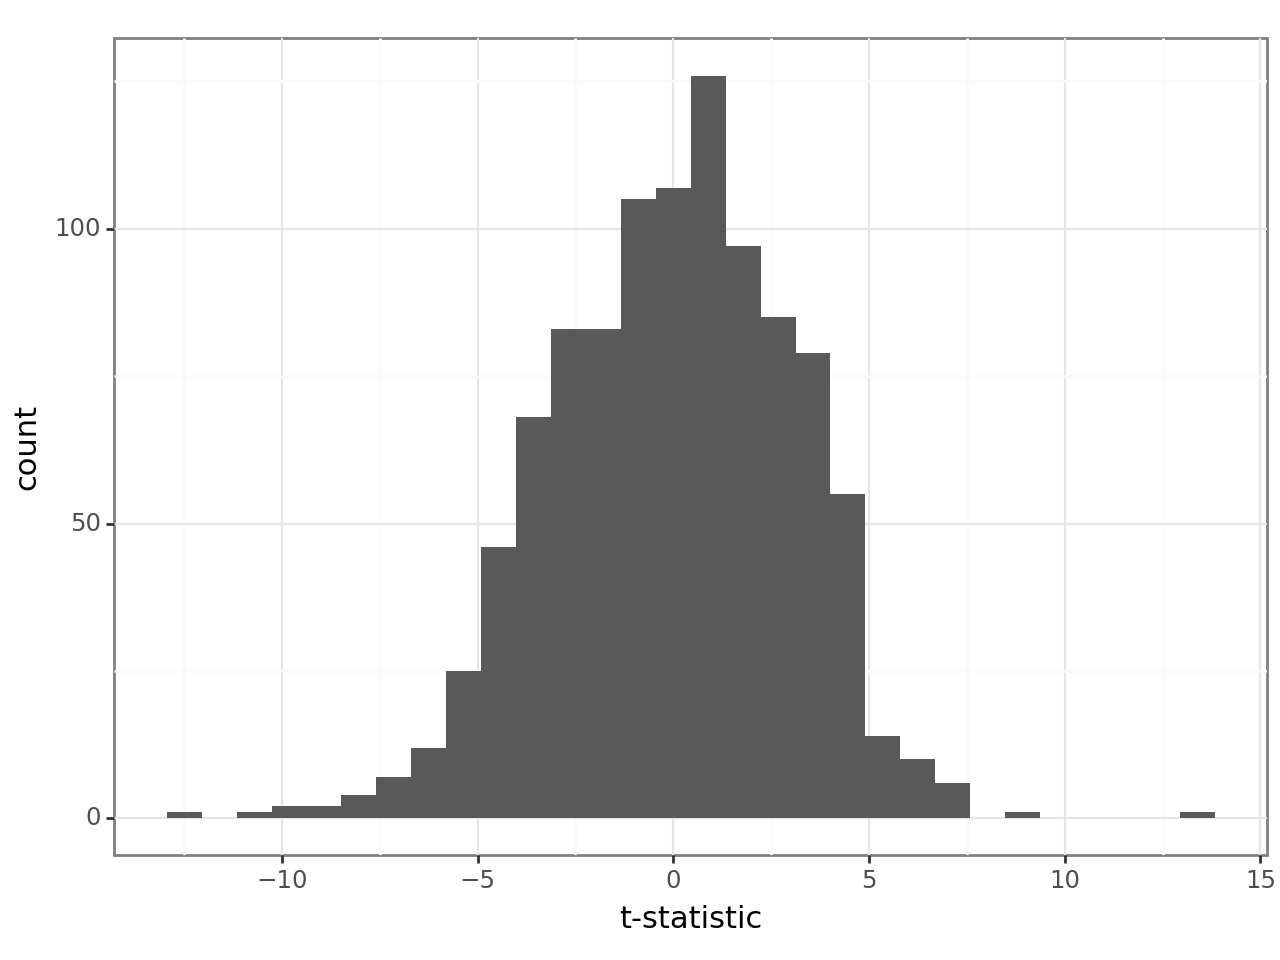

In [9]:
from plotnine import ggplot, aes, geom_histogram, theme_bw, xlab

plot1 = (ggplot(cc_res) 
+ aes(x = "z")
+ geom_histogram()
+ theme_bw()
+ xlab("t-statistic"))

print(plot1)

In [8]:
cc_reg.filter(pl.col("Metadata_gene_allele").is_in(["IER3IP1_Val21Gly", "IER3IP1"])).sort(["Metadata_gene_allele", "Platemap"])

Metadata_well_position,Metadata_Plate,Metadata_gene_allele,Cell_count,Platemap,Gene_symbol,Type
str,str,str,u32,str,str,str
"""K22""","""B7A1R1_P2T1""","""IER3IP1""",164,"""B7A1R1""","""IER3IP1""","""WT"""
"""K22""","""B7A1R1_P2T2""","""IER3IP1""",664,"""B7A1R1""","""IER3IP1""","""WT"""
"""K22""","""B7A1R1_P2T3""","""IER3IP1""",571,"""B7A1R1""","""IER3IP1""","""WT"""
"""K22""","""B7A1R1_P2T4""","""IER3IP1""",608,"""B7A1R1""","""IER3IP1""","""WT"""
"""K22""","""B8A1R2_P2T1""","""IER3IP1""",150,"""B8A1R2""","""IER3IP1""","""WT"""
"""K22""","""B8A1R2_P2T2""","""IER3IP1""",245,"""B8A1R2""","""IER3IP1""","""WT"""
"""K22""","""B8A1R2_P2T4""","""IER3IP1""",106,"""B8A1R2""","""IER3IP1""","""WT"""
"""K22""","""B8A1R2_P2T3""","""IER3IP1""",168,"""B8A1R2""","""IER3IP1""","""WT"""
"""M22""","""B7A1R1_P2T2""","""IER3IP1_Val21G…",426,"""B7A1R1""","""IER3IP1""","""VAR"""


Next, compare cell count for the same well but between batches (not between wt-variant pairs)

In [19]:
cc_reg = cc_reg.with_columns(
    pl.when(pl.col("Metadata_Plate").str.contains("B7"))
    .then(pl.lit("Batch7"))
    .otherwise(pl.lit("Batch8")).alias("Batch"),
    pl.col("Metadata_Plate").str.slice(7,2).alias("Platemap_num")
)

cc_reg = cc_reg.with_columns(pl.concat_str([pl.col("Platemap_num"), pl.col("Metadata_well_position")], separator="_").alias("Unique_well"))

unique_wells = cc_reg.select("Unique_well").to_series().unique().to_list()

In [56]:
coef = []
tstat = []
wells = []
for well in tqdm(unique_wells):
    # get data for variant
    cc_temp = cc_reg.filter(pl.col("Unique_well") == well)
    
    try:
        # perform stat test
        model = smf.ols("Cell_count ~ Batch", data=cc_temp.to_pandas())
        result = model.fit()
        
        coef.append(result.params.to_list()[1])
        tstat.append(result.tvalues.to_list()[1])
        wells.append(well)
    except Exception as e:
        print(f"An error occurred with variant {variant}: {str(e)}")

cc_batch = pl.DataFrame({
    "Unique_well": wells,
    "CC_coef": coef,
    "tstat": tstat
}
)

100%|██████████| 1480/1480 [00:08<00:00, 174.62it/s]


In [64]:
cc_reg.filter(pl.col("Unique_well") == "P3_B13").sort(["Metadata_gene_allele", "Platemap"])

Metadata_well_position,Metadata_Plate,Metadata_gene_allele,Cell_count,Platemap,Gene_symbol,Type,Batch,Platemap_num,Unique_well
str,str,str,u32,str,str,str,str,str,str
"""B13""","""B7A1R1_P3T4""","""PKP2_Ser644Pro…",1708,"""B7A1R1""","""PKP2""","""VAR""","""Batch7""","""P3""","""P3_B13"""
"""B13""","""B7A1R1_P3T3""","""PKP2_Ser644Pro…",2000,"""B7A1R1""","""PKP2""","""VAR""","""Batch7""","""P3""","""P3_B13"""
"""B13""","""B7A1R1_P3T2""","""PKP2_Ser644Pro…",1,"""B7A1R1""","""PKP2""","""VAR""","""Batch7""","""P3""","""P3_B13"""
"""B13""","""B7A1R1_P3T1""","""PKP2_Ser644Pro…",280,"""B7A1R1""","""PKP2""","""VAR""","""Batch7""","""P3""","""P3_B13"""
"""B13""","""B8A1R2_P3T4""","""PKP2_Ser644Pro…",5,"""B8A1R2""","""PKP2""","""VAR""","""Batch8""","""P3""","""P3_B13"""
"""B13""","""B8A1R2_P3T2""","""PKP2_Ser644Pro…",10,"""B8A1R2""","""PKP2""","""VAR""","""Batch8""","""P3""","""P3_B13"""
"""B13""","""B8A1R2_P3T3""","""PKP2_Ser644Pro…",7,"""B8A1R2""","""PKP2""","""VAR""","""Batch8""","""P3""","""P3_B13"""
"""B13""","""B8A1R2_P3T1""","""PKP2_Ser644Pro…",11,"""B8A1R2""","""PKP2""","""VAR""","""Batch8""","""P3""","""P3_B13"""


General variability in cell count seems to matter. Calculate that instead.

In [66]:
cc_var = cc_reg.groupby(["Unique_well", "Metadata_gene_allele"]).agg([
    pl.col("Cell_count").var().alias("variance_cell_count"),
    pl.col("Cell_count").std().alias("std_cell_count")
])



In [12]:
# get nucleus and cell area
b7_area = pl.scan_parquet("/dgx1nas1/storage/data/sam/codes/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/outputs/batch_profiles/2024_01_23_Batch_7/profiles.parquet").select(
    ['Metadata_well_position', 'Metadata_plate_map_name', 'Metadata_ImageNumber', 'Metadata_gene_allele', 'Metadata_Plate', 'Nuclei_AreaShape_Area', 'Cells_AreaShape_Area']
).with_columns(
    (pl.col("Nuclei_AreaShape_Area")/pl.col("Cells_AreaShape_Area")).alias("Nucleus_Cell_Area")
    ).groupby(
        ['Metadata_Plate', 'Metadata_well_position', 'Metadata_ImageNumber']
        ).agg([
            pl.col("Nucleus_Cell_Area").mean().alias("Nucleus_Cell_Area"),
            pl.count().alias("Cell_count")
        ]).collect()
b7_area = b7_area.with_columns((pl.col("Nucleus_Cell_Area")*pl.col("Cell_count")).alias("AR_times_CC"))       


b8_area = pl.scan_parquet("/dgx1nas1/storage/data/sam/codes/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/outputs/batch_profiles/2024_02_06_Batch_8/profiles.parquet").select(
    ['Metadata_well_position', 'Metadata_plate_map_name', 'Metadata_ImageNumber', 'Metadata_gene_allele', 'Metadata_Plate', 'Nuclei_AreaShape_Area', 'Cells_AreaShape_Area']
).with_columns(
    (pl.col("Nuclei_AreaShape_Area")/pl.col("Cells_AreaShape_Area")).alias("Nucleus_Cell_Area")
    ).groupby(
        ['Metadata_Plate', 'Metadata_well_position', 'Metadata_ImageNumber']
        ).agg([
            pl.col("Nucleus_Cell_Area").mean().alias("Nucleus_Cell_Area"),
            pl.count().alias("Cell_count")
        ]).collect()
b8_area = b8_area.with_columns((pl.col("Nucleus_Cell_Area")*pl.col("Cell_count")).alias("AR_times_CC"))   

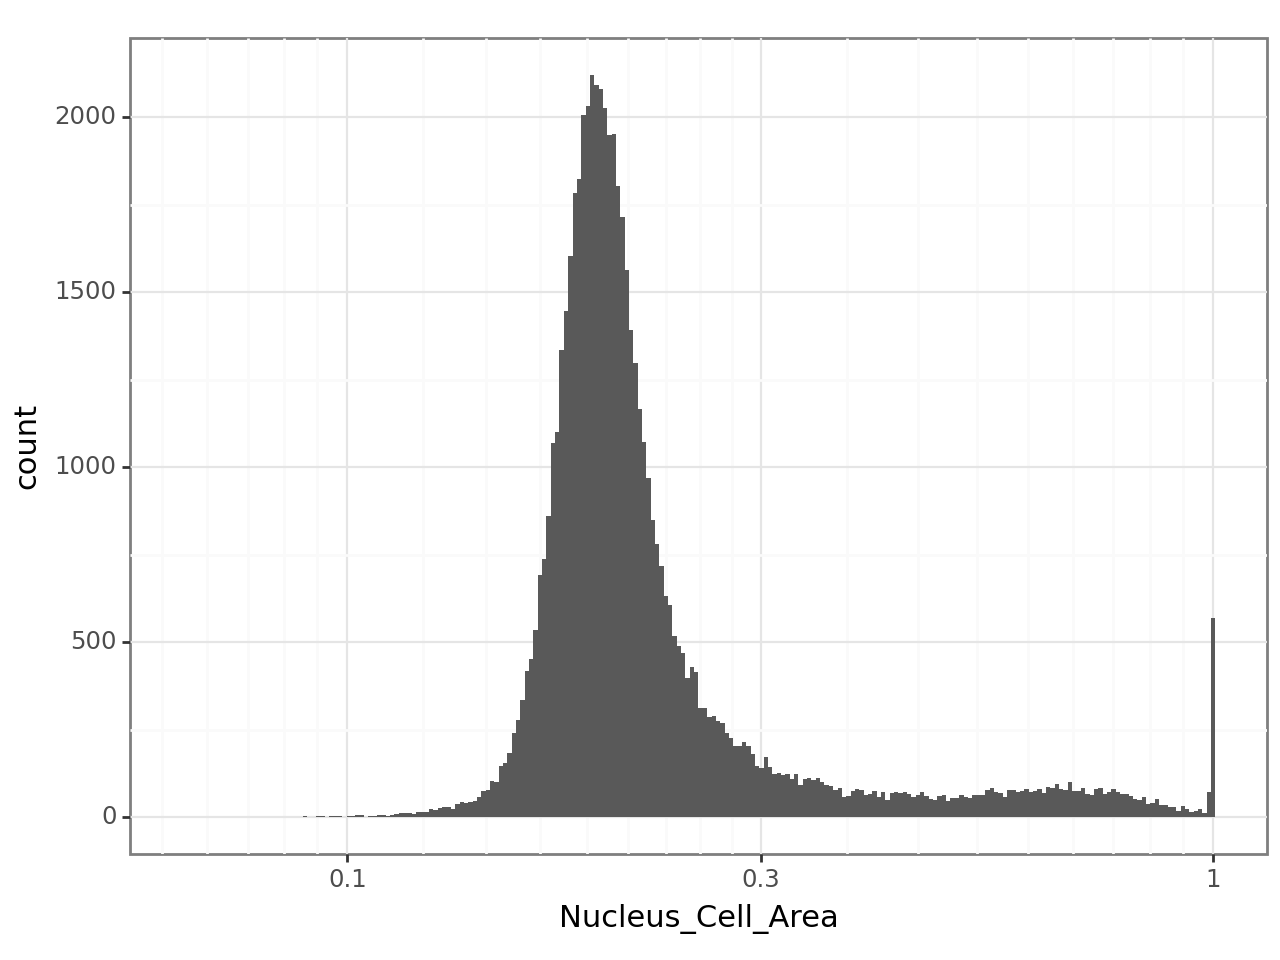

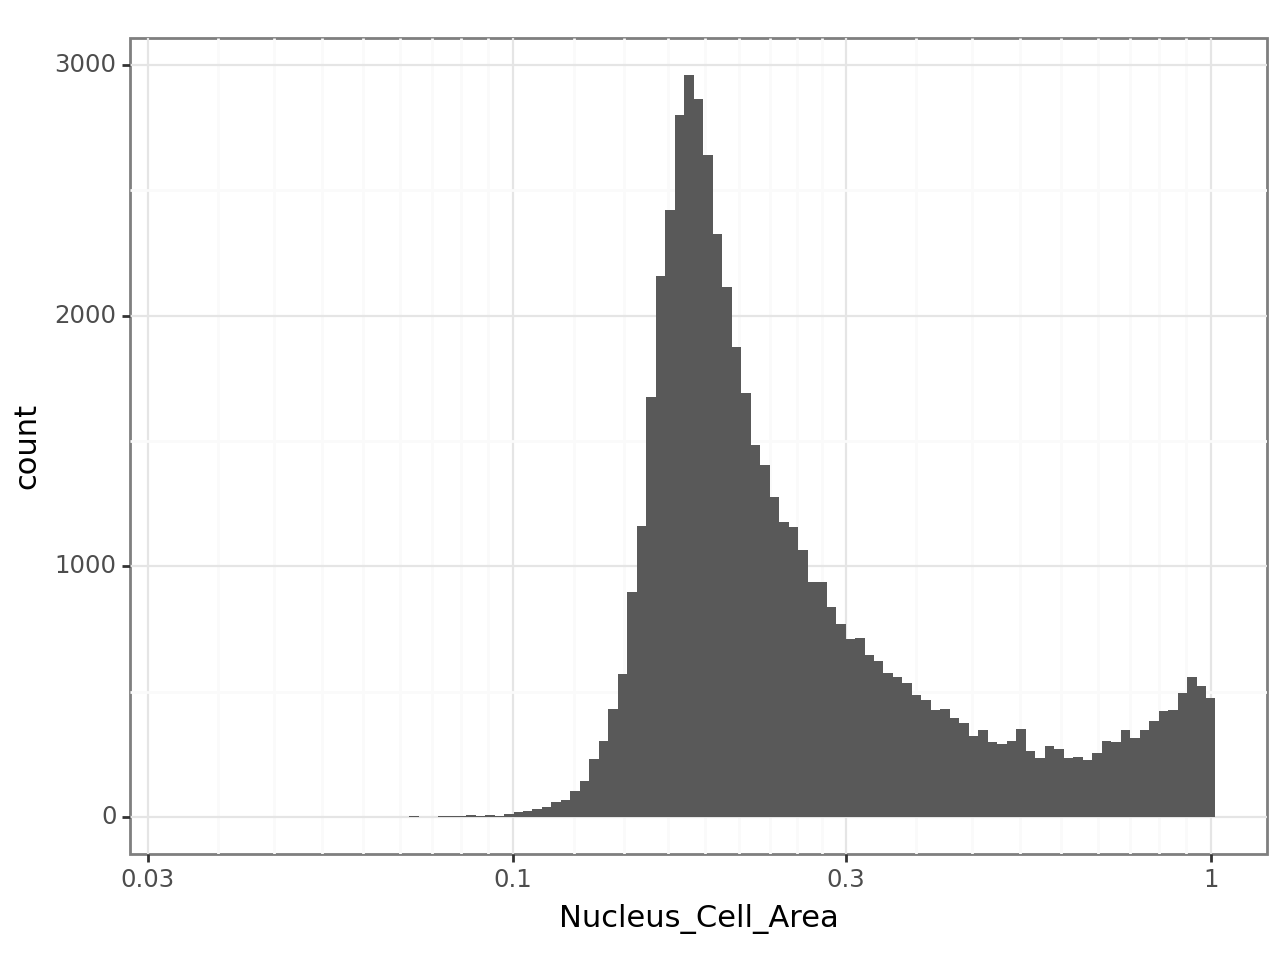

In [82]:
from plotnine import ggplot, aes, geom_histogram, theme_bw, xlab, scale_x_log10

plot1 = (ggplot(b7_area) 
+ aes(x = "Nucleus_Cell_Area")
+ geom_histogram()
+ theme_bw()
+ scale_x_log10())

print(plot1)

plot2 = (ggplot(b8_area) 
+ aes(x = "Nucleus_Cell_Area")
+ geom_histogram()
+ theme_bw()
+ scale_x_log10())

print(plot2)

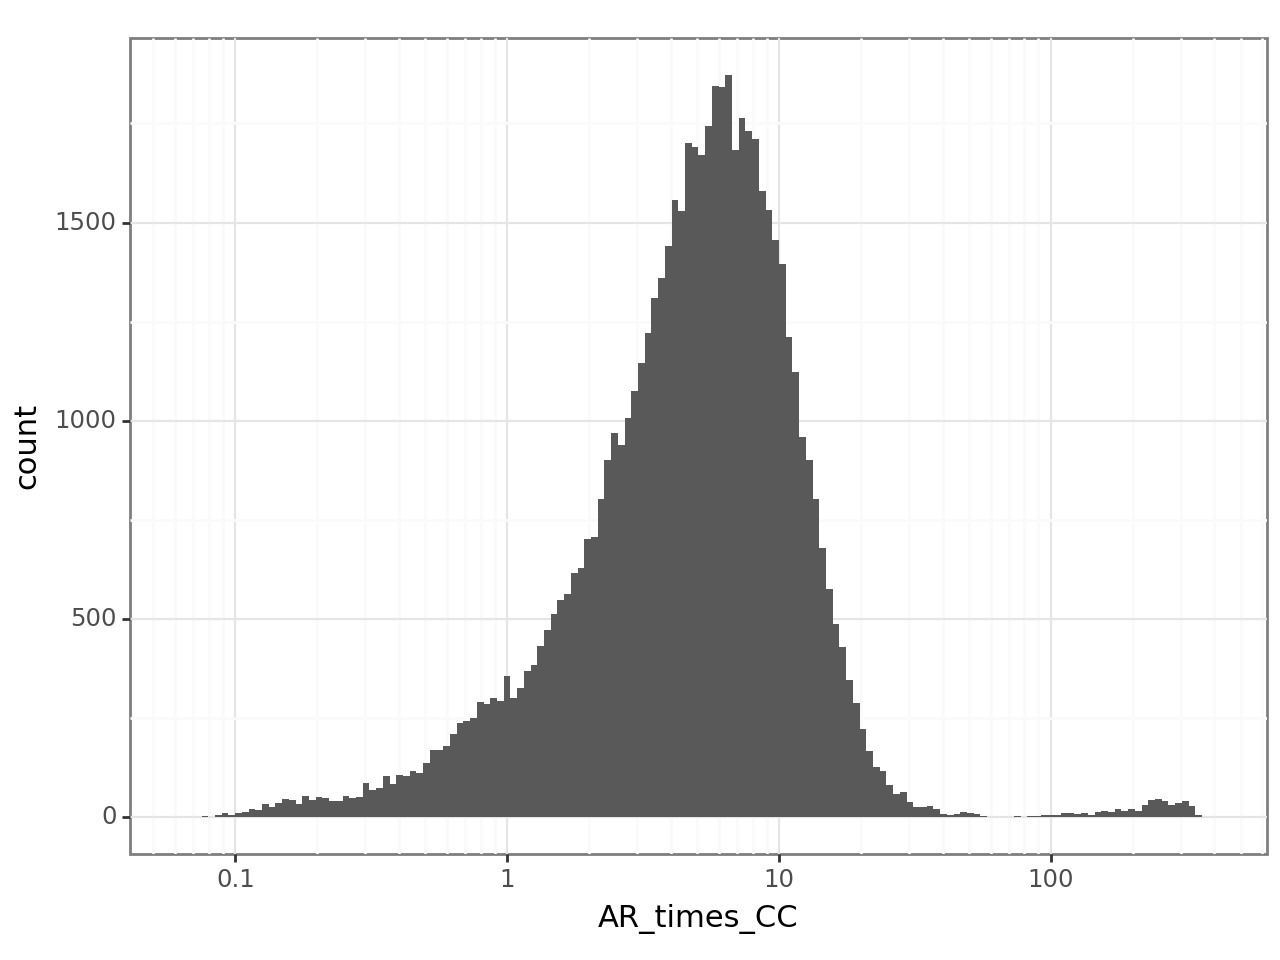

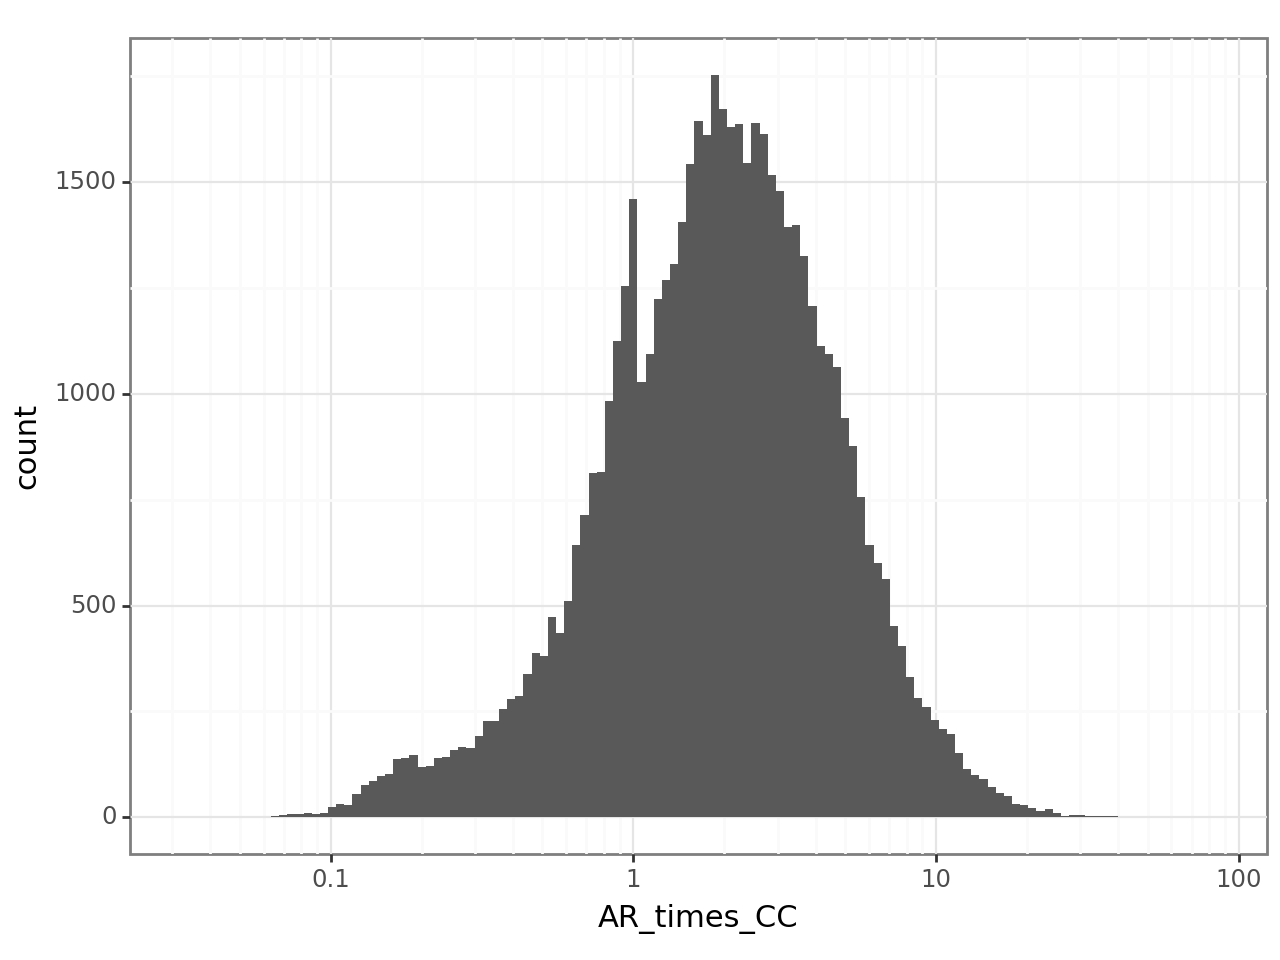

In [81]:
from plotnine import ggplot, aes, geom_histogram, theme_bw, xlab, scale_x_log10

plot1 = (ggplot(b7_area) 
+ aes(x = "AR_times_CC")
+ geom_histogram()
+ theme_bw()
+ scale_x_log10())

print(plot1)

plot2 = (ggplot(b8_area) 
+ aes(x = "AR_times_CC")
+ geom_histogram()
+ theme_bw()
+ scale_x_log10())

print(plot2)

In [13]:
# Look at distribution of nucleus area : cell area for single cells

b7_filt = pl.scan_parquet("/dgx1nas1/storage/data/sam/codes/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/outputs/batch_profiles/2024_01_23_Batch_7/profiles.parquet").select(
    ['Metadata_well_position', 'Metadata_plate_map_name', 'Metadata_ImageNumber', 'Metadata_gene_allele', 'Metadata_Plate', 'Nuclei_AreaShape_Area', 'Cells_AreaShape_Area']
).with_columns(
    (pl.col("Nuclei_AreaShape_Area")/pl.col("Cells_AreaShape_Area")).alias("Nucleus_Cell_Area")
    ).collect()

b8_filt = pl.scan_parquet("/dgx1nas1/storage/data/sam/codes/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/outputs/batch_profiles/2024_02_06_Batch_8/profiles.parquet").select(
    ['Metadata_well_position', 'Metadata_plate_map_name', 'Metadata_ImageNumber', 'Metadata_gene_allele', 'Metadata_Plate', 'Nuclei_AreaShape_Area', 'Cells_AreaShape_Area']
).with_columns(
    (pl.col("Nuclei_AreaShape_Area")/pl.col("Cells_AreaShape_Area")).alias("Nucleus_Cell_Area")
    ).collect()


plot1 = (ggplot(b7_filt) 
+ aes(x = "Nucleus_Cell_Area")
+ geom_histogram()
+ theme_bw()
+ scale_x_log10())

print(plot1)

plot2 = (ggplot(b8_filt) 
+ aes(x = "Nucleus_Cell_Area")
+ geom_histogram()
+ theme_bw()
+ scale_x_log10())

print(plot2)

#.filter(pl.col("Nucleus_Cell_Area") < 0.5).group_by(['Metadata_well_position', 'Metadata_Plate', 'Metadata_gene_allele']).agg(pl.count().alias("Cell_count")).collect()



NameError: name 'ggplot' is not defined

## Re-do cell count analysis between WT and VAR, after filtering cells based on nuclear:cellular area ratio

From plots above, I see that the typical cell should have a nuclear : cellular area ratio of between 0.1 and 0.4. Others are likely to be segmentation errors. It's possible that I may lose some real cells that are just particularly crowded or dividing, however losing this small number shouldn't impact the overall results.

In [14]:
# Get cell count per well
cc = pl.scan_parquet("/dgx1nas1/storage/data/sam/codes/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/outputs/batch_profiles/2024_01_23_Batch_7/profiles.parquet")
cc = cc.select(['Metadata_well_position', 'Metadata_Plate', 'Metadata_gene_allele', 'Nuclei_AreaShape_Area', 'Cells_AreaShape_Area']).with_columns(
    (pl.col("Nuclei_AreaShape_Area")/pl.col("Cells_AreaShape_Area")).alias("Nucleus_Cell_Area")
    ).filter((pl.col("Nucleus_Cell_Area") > 0.1) & (pl.col("Nucleus_Cell_Area") < 0.4)).collect()
cc = cc.group_by(['Metadata_well_position', 'Metadata_Plate', 'Metadata_gene_allele']).agg(pl.count().alias("Cell_count"))
cc = cc.with_columns(pl.col("Metadata_Plate").str.slice(11, 22).alias("Metadata_Plate"))

cc8 = pl.scan_parquet("/dgx1nas1/storage/data/sam/codes/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/outputs/batch_profiles/2024_02_06_Batch_8/profiles.parquet")
cc8 = cc8.select(['Metadata_well_position', 'Metadata_Plate', 'Metadata_gene_allele','Nuclei_AreaShape_Area', 'Cells_AreaShape_Area']).with_columns(
    (pl.col("Nuclei_AreaShape_Area")/pl.col("Cells_AreaShape_Area")).alias("Nucleus_Cell_Area")
    ).filter((pl.col("Nucleus_Cell_Area") > 0.1) & (pl.col("Nucleus_Cell_Area") < 0.4)).collect()
cc8 = cc8.group_by(['Metadata_well_position', 'Metadata_Plate', 'Metadata_gene_allele']).agg(pl.count().alias("Cell_count"))
cc8 = cc8.with_columns(pl.col("Metadata_Plate").str.slice(11, 22).alias("Metadata_Plate"))

cc = pl.concat([cc, cc8])

In [16]:
cc.write_csv("/dgx1nas1/storage/data/jess/varchamp/b7b8_cellcount_filtered.csv")

In [15]:
# Add extra annotations
cc_reg = cc.with_columns(
    pl.col("Metadata_Plate").str.replace("_.*", "").alias("Platemap"),
    pl.col("Metadata_gene_allele").str.replace("_.*", "").alias("Gene_symbol"),
    pl.when(pl.col("Metadata_gene_allele").str.contains("_")).then(pl.lit("VAR")).otherwise(pl.lit("WT")).alias("Type")
)
variants = cc_reg.filter(pl.col("Type") == "VAR").select("Metadata_gene_allele").to_series().unique().to_list()
genes = cc_reg.select("Gene_symbol").to_series().unique().to_list()

In [5]:
cc_res = []
for variant in tqdm(variants):
    # get data for variant
    gene_symb = variant.split("_")[0]
    
    # ensure that only wt-var pairs on same plate are included
    var_cc = cc_reg.filter(pl.col("Metadata_gene_allele") == variant)
    var_plates = var_cc.select("Metadata_Plate").to_series().unique().to_list()
    wt_cc = cc_reg.filter((pl.col("Metadata_gene_allele") == gene_symb) &
                          (pl.col("Metadata_Plate").is_in(var_plates)))
    wt_plates = wt_cc.select("Metadata_Plate").to_series().unique().to_list()
    var_cc = var_cc.filter(pl.col("Metadata_Plate").is_in(wt_plates))
    
    var_cc = pl.concat([var_cc, wt_cc])
    
    try:
        # perform stat test
        model = smf.mixedlm("Cell_count ~ Type", data=var_cc.to_pandas(), groups=var_cc.to_pandas()["Metadata_Plate"])
        result = model.fit()
        
        # format results
        summary_df = pl.DataFrame(result.summary().tables[1][1:2])
        summary_df = summary_df.with_columns(
            [pl.col(column).cast(pl.Float64).alias(column) for column in summary_df.columns]
        )
        summary_df = summary_df.with_columns(
            pl.lit(variant).alias("Variant"),
            pl.lit(gene_symb).alias("Gene")
        )
        
        # append results
        cc_res.append(summary_df)
    except Exception as e:
        print(f"An error occurred with variant {variant}: {str(e)}")

cc_res = pl.concat(cc_res)

  3%|▎         | 27/1028 [00:00<00:33, 29.84it/s]

An error occurred with variant TMEM43_Arg28Trp: negative dimensions are not allowed


  5%|▍         | 51/1028 [00:01<00:29, 33.56it/s]

An error occurred with variant TMEM43_Arg312Trp: negative dimensions are not allowed


 15%|█▌        | 156/1028 [00:05<00:30, 28.56it/s]

An error occurred with variant TMEM43_Arg220Cys: negative dimensions are not allowed


 16%|█▋        | 168/1028 [00:06<00:29, 29.06it/s]

An error occurred with variant DCX_Ala251Ser: Singular matrix


 19%|█▊        | 192/1028 [00:06<00:26, 31.03it/s]

An error occurred with variant MLH1_Val716Met: conversion from `str` to `f64` failed in column 'P>|z|' for 1 out of 1 values: [""]
An error occurred with variant TMEM43_Glu85Lys: negative dimensions are not allowed


 40%|███▉      | 407/1028 [00:14<00:20, 30.44it/s]

An error occurred with variant NR0B1_Lys382Asn: negative dimensions are not allowed
An error occurred with variant BLMH_Ile443Val: negative dimensions are not allowed


 45%|████▍     | 460/1028 [00:16<00:22, 25.50it/s]

An error occurred with variant SFTPA2_Gln223Lys: Singular matrix


 46%|████▌     | 472/1028 [00:17<00:24, 22.64it/s]

An error occurred with variant TMEM43_Arg299Thr: negative dimensions are not allowed


 51%|█████     | 525/1028 [00:19<00:19, 25.94it/s]

An error occurred with variant COMP_Asp408Asn: Singular matrix


 57%|█████▋    | 588/1028 [00:22<00:16, 27.12it/s]

An error occurred with variant KRT83_Glu407Lys: Singular matrix


 61%|██████▏   | 632/1028 [00:23<00:13, 29.73it/s]

An error occurred with variant PKP2_Ser644Pro: conversion from `str` to `f64` failed in column 'Std.Err.' for 1 out of 1 values: [""]


 65%|██████▌   | 670/1028 [00:25<00:12, 28.97it/s]

An error occurred with variant TPM1_Asp175Asn: Singular matrix
An error occurred with variant TMEM43_Thr277Ser: negative dimensions are not allowed


 76%|███████▋  | 785/1028 [00:29<00:08, 29.73it/s]

An error occurred with variant GFAP_Glu371Val: Singular matrix


 86%|████████▌ | 885/1028 [00:32<00:04, 31.13it/s]

An error occurred with variant TMEM43_Tyr371His: negative dimensions are not allowed


 99%|█████████▊| 1014/1028 [00:37<00:00, 34.05it/s]

An error occurred with variant TMEM43_Ala366Thr: negative dimensions are not allowed


100%|██████████| 1028/1028 [00:37<00:00, 27.19it/s]


In [6]:
def calculate_p_value(z):
    # Calculate the two-tailed p-value
    return 2 * (1 - stats.norm.cdf(abs(z)))

cc_res = cc_res.with_columns(
    pl.col("z").apply(calculate_p_value).alias("p_value")
)

# muliple hypothesis corrections
p_values = cc_res["p_value"].to_numpy()
_, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
cc_res = cc_res.with_columns(pl.Series("fdr", pvals_corrected))

In [7]:
print(cc_res.shape)
print(cc_res.filter(pl.col("fdr") < 0.05).shape)
print(cc_res.filter(pl.col("z") > 0).shape)

(1010, 10)
(536, 10)
(505, 10)


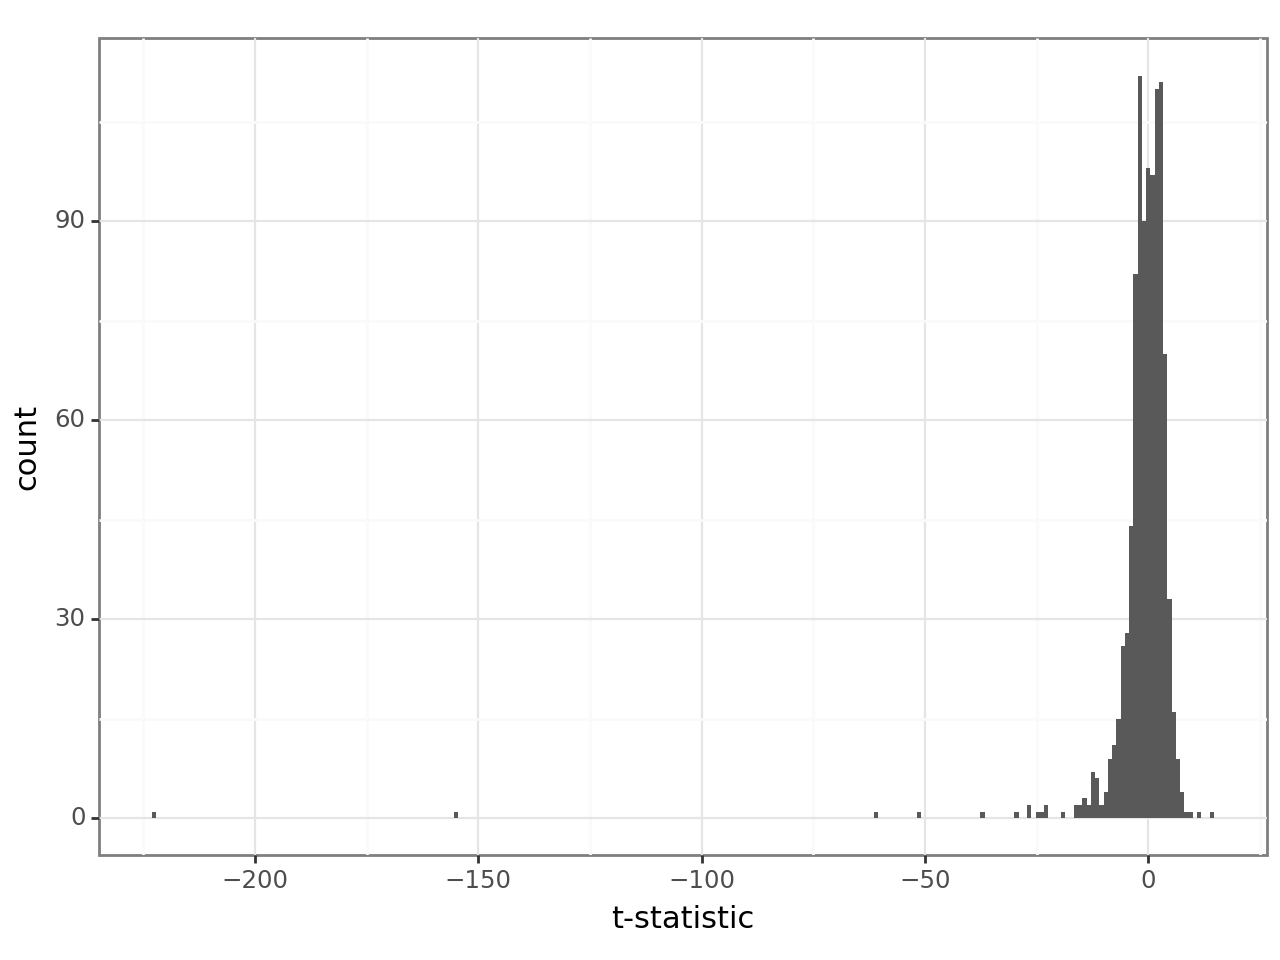

In [8]:
from plotnine import ggplot, aes, geom_histogram, theme_bw, xlab

plot1 = (ggplot(cc_res) 
+ aes(x = "z")
+ geom_histogram()
+ theme_bw()
+ xlab("t-statistic"))

print(plot1)

# negative values = lower in WT than in VAR